In [62]:
# Imports for model building and classification
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Load the breast cancer dataset
breast_cancer_data = load_breast_cancer()

# Read in the project3 dataset
project3_data = pd.read_csv("Project3_Dataset.csv")

# 1. Classification on the Breast Cancer dataset #
## Task 1: Building the Best Baseline Model ##

Basline Classifier Accuracies:
Logistic Regression: 97.66%
KNN: 95.91%
ANN: 95.91%
Decision Tree: 94.15%
Naive Bayes: 94.15%
SVM: 93.57%

Best Classifier is Logistic Regression with an accuracy of 97.66%

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

   malignant       0.97      0.97      0.97        63
      benign       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



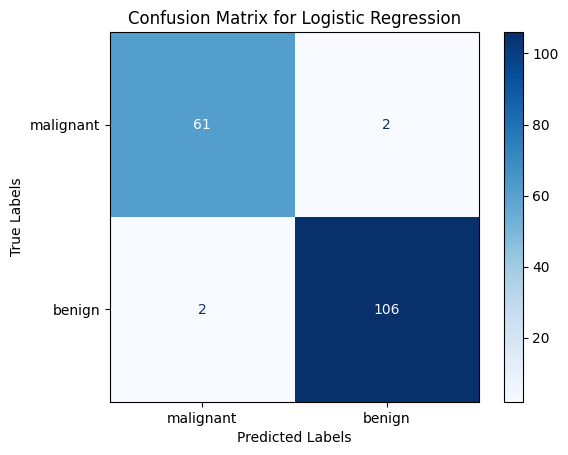

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 97.74%

Updated Classification Report for Hypertuned Logistic Regression:

              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99        63
      benign       0.99      1.00      1.00       108

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Updated accuracy: Logistic Regression: 99.42%



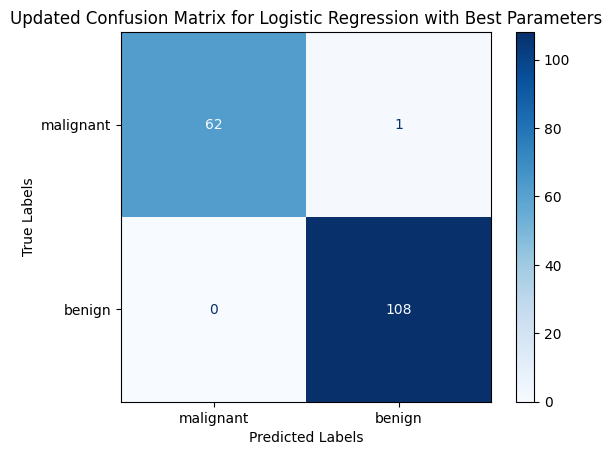

In [63]:
# Split the data into features (X) and target (y)
X = breast_cancer_data.data
y = breast_cancer_data.target

# Split into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a dictionary of classifiers for testing (max_iter values set to avoid convergence failure warnings upon hitting the default max iterations)
baseline_classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'ANN': MLPClassifier(random_state=42, max_iter=5000),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000)
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in baseline_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results.append((name, accuracy))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_baseline_classifier_name, best_baseline_classifier_accuracy = results[0]
best_baseline_classifier = baseline_classifiers[best_baseline_classifier_name]

# Generate predictions using the best classifier
y_pred = best_baseline_classifier.predict(X_test)

# Display the classification results 
print("Basline Classifier Accuracies:")
for name, accuracy in results:
    print(f"{name}: {accuracy * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_baseline_classifier_name} with an accuracy of {best_baseline_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred, target_names=breast_cancer_data.target_names))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=breast_cancer_data.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_baseline_classifier_name}")
plt.show()

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
baseline_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers
    'penalty': ['l2']
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
baseline_grid_search = GridSearchCV(estimator=best_baseline_classifier, param_grid=baseline_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
baseline_grid_search.fit(X_train_scaled, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_baseline_params = baseline_grid_search.best_params_
best_baseline_model = baseline_grid_search.best_estimator_

print(f"Best Parameters: {best_baseline_params}")
print(f"Best Cross-Validation Accuracy: {baseline_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_baseline_model.predict(X_test_scaled)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, target_names=breast_cancer_data.target_names))
print(f"Updated accuracy: {best_baseline_classifier_name}: {best_baseline_model.score(X_test_scaled, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated, display_labels=breast_cancer_data.target_names)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_baseline_classifier_name} with Best Parameters")
plt.show()




## Task 2: Building the Best Ensemble Model ##

Basline Classifier Accuracies:
RandomForest: 97.08%
AdaBoost: 97.08%
GradientBoosting: 95.91%
Bagging: 94.74%

Best Classifier is RandomForest with an accuracy of 97.08%

Classification Report for RandomForest:

              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



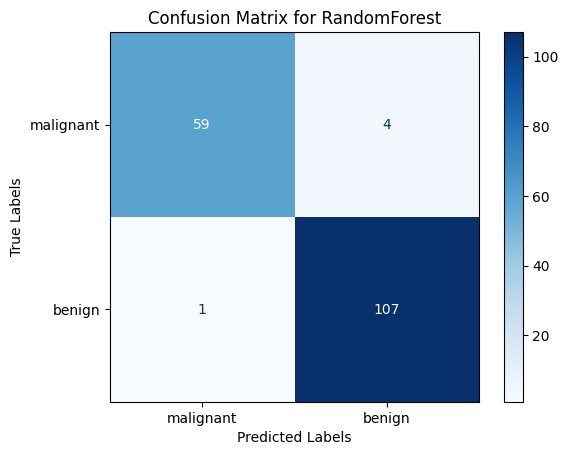

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 400}
Best Cross-Validation Accuracy: 95.72%

Updated Classification Report for Hypertuned RandomForest:

              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

Updated accuracy: RandomForest: 97.08%



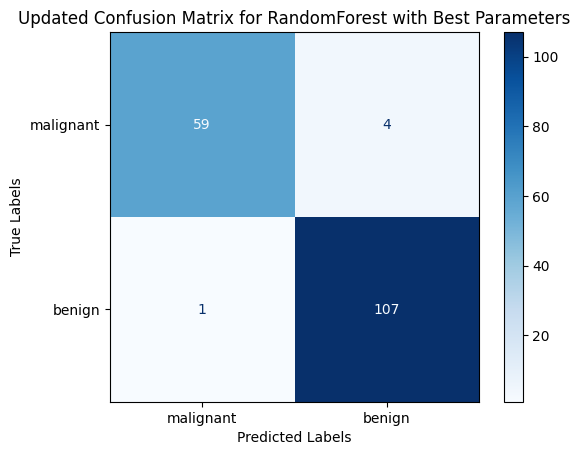

In [70]:
# Split the data into features (X) and target (y)
X = breast_cancer_data.data
y = breast_cancer_data.target

# Split into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a dictionary of classifiers for testing (algorithm="SAMME.R" prevents deprication warning)
ensemble_classifiers = {
    'Bagging': BaggingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in ensemble_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results.append((name, accuracy))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_ensemble_classifier_name, best_ensemble_classifier_accuracy = results[0]
best_ensemble_classifier = ensemble_classifiers[best_ensemble_classifier_name]

# Generate predictions using the best classifier
y_pred = best_ensemble_classifier.predict(X_test)

# Display the classification results 
print("Basline Classifier Accuracies:")
for name, accuracy in results:
    print(f"{name}: {accuracy * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_ensemble_classifier_name} with an accuracy of {best_ensemble_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred, target_names=breast_cancer_data.target_names))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=breast_cancer_data.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_ensemble_classifier_name}")
plt.show()

# Define the parameter grid
ensemble_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
ensemble_grid_search = GridSearchCV(estimator=best_ensemble_classifier, param_grid=ensemble_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
ensemble_grid_search.fit(X_train, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_params = ensemble_grid_search.best_params_
best_ensemble_model = ensemble_grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {ensemble_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_ensemble_model.predict(X_test)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, target_names=breast_cancer_data.target_names))
print(f"Updated accuracy: {best_ensemble_classifier_name}: {best_ensemble_model.score(X_test, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated, display_labels=breast_cancer_data.target_names)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_ensemble_classifier_name} with Best Parameters")
plt.show()




# 2. Classification on the attached dataset (Project3_Dataset.csv) #
## Task 1: Normalizing the Features ##

In [65]:
# Separate features (columns 1 to 65) and labels (column 66)
X = project3_data.iloc[:, :65].values  # Features (columns 1 to 65)
y = project3_data.iloc[:, 65].values   # Labels (column 66)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)